Online tutorial on Convolutional VAE from tensorflow, see [cvae](https://github.com/tensorflow/tensorflow/blob/r1.13/tensorflow/contrib/eager/python/examples/generative_examples/cvae.ipynb)

In [82]:
from platform import python_version
print(python_version())

3.5.2


In [83]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
tfe = tf.contrib.eager
tf.enable_eager_execution()

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
from IPython import display

In [29]:
tf.keras.backend.set_floatx('float32')

In [46]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_imagestrain_i  = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

# train_imagestrain_i = train_imagestrain_i.astype('float32')
# test_images = test_images.astype('float32')
# Normalizing the images to the range of [0., 1.]
train_images = train_images/255.
test_images = test_images/255.

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

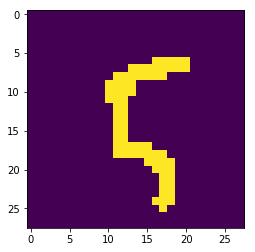

In [48]:
plt.imshow(train_images[100, :, :])

In [49]:
TRAIN_BUF  = 60000
BATCH_SIZE = 100

TEST_BUF = 10000

In [68]:
train_images = train_images.reshape((-1, 28, 28, 1))
test_images = test_images.reshape((-1, 28, 28, 1))

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [69]:
train_dataset
train_images.shape

(60000, 28, 28, 1)

In [70]:
class CVAE(tf.keras.Model):
    
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        # q(z|x)
        self.inference_net = tf.keras.Sequential([
          tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
          tf.keras.layers.Conv2D(
              filters=32, kernel_size=3, strides=(2, 2), activation=tf.nn.relu),
          tf.keras.layers.Conv2D(
              filters=64, kernel_size=3, strides=(2, 2), activation=tf.nn.relu),
          tf.keras.layers.Flatten(),
          # No activation
          tf.keras.layers.Dense(latent_dim + latent_dim),
        ])
        # p(x|z)
        self.generative_net = tf.keras.Sequential([
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation=tf.nn.relu),
          tf.keras.layers.Conv2DTranspose(
              filters=32,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation=tf.nn.relu),
          # No activation
          tf.keras.layers.Conv2DTranspose(
              filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
        ])

    def sample(self, eps=None):
        if eps is None:
              eps = tf.random_normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random_normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

## Define the loss function and the optimizer 

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$\log p_{\mathbf{\theta}}(\mathbf{x}) \geq	\mathcal{L}(\mathbf{\theta}, \mathbf{\phi}; \mathbf{x}) =
\mathbb{E}_{p_{\mathbf{\phi}}(\mathbf{z}|\mathbf{x})} \left[ \log p_{\mathbf{\theta}}(\mathbf{x}, \mathbf{z})
- \log p_{\mathbf{\phi}}(\mathbf{z}|\mathbf{x})\right]$

which can be rewriten in terms of the KL divergence.
In practice, we optimize the single sample Monte Carlo estimate of this expectation:

$\log p_{\mathbf{\theta}}(\mathbf{x}|\mathbf{z}) + \log p_{\mathbf{\theta}}(\mathbf{z}) - \log p(\mathbf{z}|\mathbf{x})$

where $\mathbf{z}$ is sampled from $p_{\mathbf{\phi}}(\mathbf{z}|\mathbf{x})$.

In [76]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x) 
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)

    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


def compute_gradients(model, x):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    return tape.gradient(loss, model.trainable_variables), loss


def apply_gradients(optimizer, gradients, variables, global_step=None):
    optimizer.apply_gradients(zip(gradients, variables), global_step=global_step)


## Training

In [72]:
epochs = 100
latent_dim = 50
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random_normal(shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [55]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model.sample(test_input)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        data = predictions[i, :, :, 0]
        plt.imshow(data, cmap='gray')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

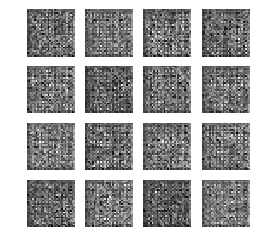

In [56]:
generate_and_save_images(model, 0, random_vector_for_generation)

Epoch: 100, Test set ELBO: -78.10847885131835, time elapse for current epoch 36.00475335121155


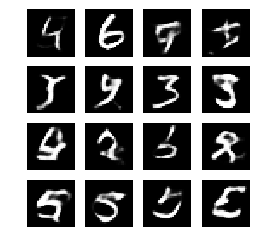

In [78]:
optimizer = tf.train.AdamOptimizer(1e-4)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        gradients, loss = compute_gradients(model, train_x)
        apply_gradients(optimizer, gradients, model.trainable_variables)
    end_time = time.time()

    if epoch % 1 == 0:
        loss = tfe.metrics.Mean()
        for test_x in test_dataset:
            loss(compute_loss(model, test_x))
        elbo = -loss.result()
        display.clear_output(wait=False)
        print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
        generate_and_save_images(model, epoch, random_vector_for_generation)

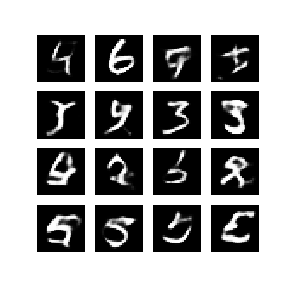

In [80]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))
display_image(epochs)  # Display images


In [81]:
with imageio.get_writer('cvae.gif', mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
          continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
# this is a hack to display the gif inside the notebook
os.system('cp cvae.gif cvae.gif.png')

ImportError: Imageio Pillow plugin requires Pillow, not PIL!